In [1]:
!/usr/bin/env python
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import sys
import shutil

from os import listdir
from os.path import isfile, join
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import *


from config import *

In [2]:
def list_npz_files(filepath=OUTPUT_DIR):
    files = [filepath+f for f in listdir(filepath) if isfile(join(filepath, f))]
    return files

In [3]:
class DeepNetwork(Model):
    def __init__(self):
        super(DeepNetwork, self).__init__()
         self.input_shape = input_shape
         self.input_layer = Input(shape = input_shape)
        self.twin_block1 = TwinBlock()
        self.twin_block2 = TwinBlock()
        self.denseBlock = DenseBlock()
    def call(self, inputs):
        inputs = self.input_layer
        x = self.twin_block1(inputs)
        y = self.twin_block2(inputs)
        z = self.denseBlock([x,y])
        return z
    def plot_history(self, history):
         ACCURACY  
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

         LOSS  
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

def TwinBlock():
    block = Sequential([
        Conv1D(16, 2, activation = 'relu', padding = 'same'),
        MaxPool1D(2),
        BatchNormalization(),
        Bidirectional(LSTM(32, return_sequences = True), merge_mode = 'concat'),
        Conv1D(32, 2, activation = 'relu', padding = 'same'),
        MaxPool1D(2),
        BatchNormalization(),
        Bidirectional(LSTM(32, return_sequences = True), merge_mode = 'concat'),
    ])
   
    return block

def DenseBlock():
    block = Sequential([
        Concatenate(),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    
    return block

In [4]:
def initDeepNet():
    deep = DeepNetwork()
    deep.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['categorical_accuracy'])
    deep.build((None, 3000,1))
    deep.summary()
    return deep

In [5]:
def load_single_npz(file):
    with np.load(file) as f:
        data = f["x"]
        labels = f["y"]
    return data, labels

In [6]:
def denseNet():
    activation = tf.keras.activations.elu
    model = Sequential([
        Flatten(),
        Dense(64, activation=activation),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [7]:
data, labels = load_single_npz('data_2018/SC4001E0.npz')

model = initDeepNet()

Consider rewriting this model with the Functional API.
Model: "deep_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 750, 64)           33552     
_________________________________________________________________
sequential_1 (Sequential)    (None, 750, 64)           33552     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  6144389   
Total params: 6,211,493
Trainable params: 6,211,301
Non-trainable params: 192
_________________________________________________________________


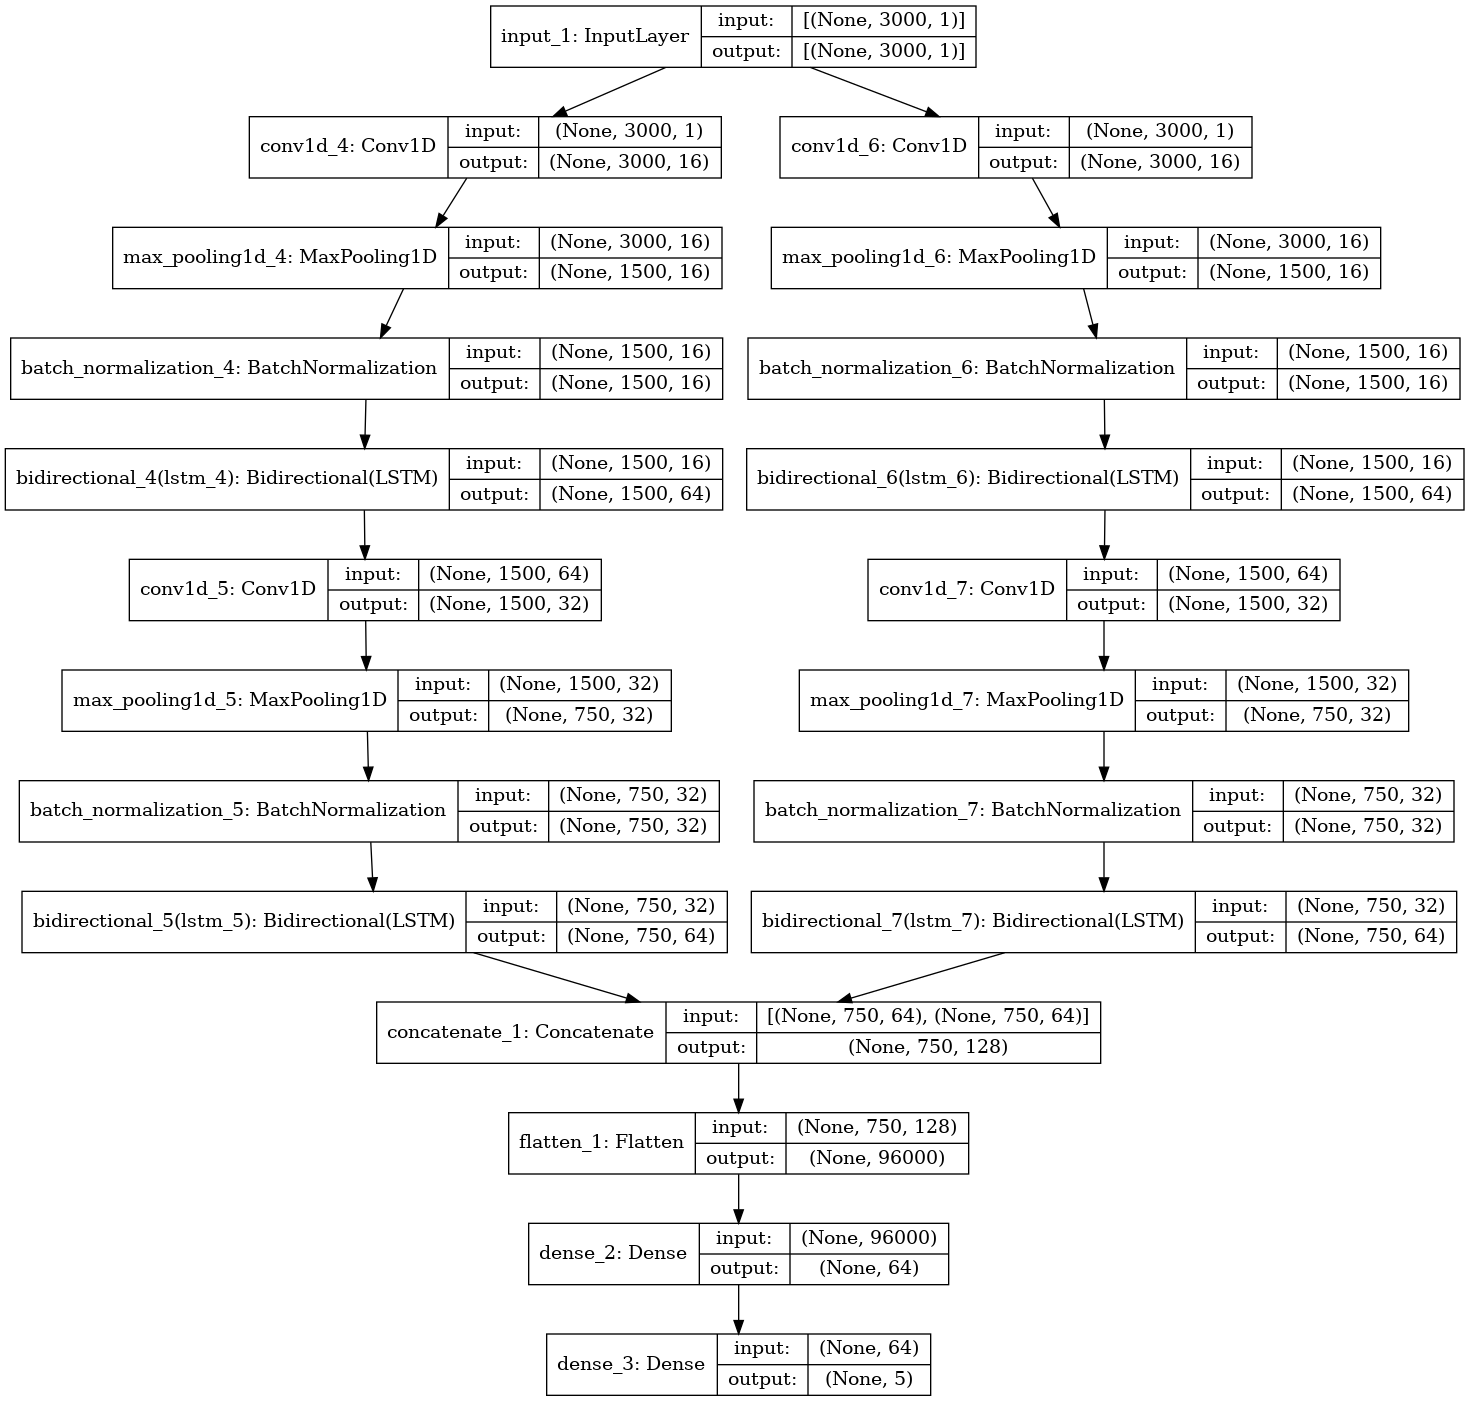

In [11]:
file = 'model.png'
tf.keras.utils.plot_model(model, to_file=file, show_shapes=True, show_layer_names=True)

In [10]:
x = Input(shape = (3000,1))
y = Conv1D(16, 2, activation = 'relu', padding = 'same')(x)
y = MaxPool1D(2)(y)
y = BatchNormalization()(y)
y = Bidirectional(LSTM(32, return_sequences = True), merge_mode = 'concat')(y)

y = Conv1D(32, 2, activation = 'relu', padding = 'same')(y)
y = MaxPool1D(2)(y)
y = BatchNormalization()(y)
f = Bidirectional(LSTM(32, return_sequences = True), merge_mode = 'concat')(y)
print(f.shape)

y = Conv1D(16, 2, activation = 'relu', padding = 'same')(x)
y = MaxPool1D(2)(y)
y = BatchNormalization()(y)
y = Bidirectional(LSTM(32, return_sequences = True), merge_mode = 'concat')(y)

y = Conv1D(32, 2, activation = 'relu', padding = 'same')(y)
y = MaxPool1D(2)(y)
y = BatchNormalization()(y)
l = Bidirectional(LSTM(32, return_sequences = True), merge_mode = 'concat')(y)
print(l.shape)

con = concatenate([f,l])
print(con.shape)

f = Flatten()(con)
dense1 = Dense(64, activation='relu')(f)
output = Dense(5, activation='softmax')(dense1)

model = Model(inputs = x, outputs = output)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


(None, 750, 64)
(None, 750, 64)
(None, 750, 128)


In [12]:
history = model.fit(data, labels, epochs = 10,
                    verbose = 1)

Epoch 1/10
27/27 [==============================] - 34s 979ms/step - loss: 1.2677 - accuracy: 0.5058
Epoch 2/10
27/27 [==============================] - 25s 912ms/step - loss: 0.9934 - accuracy: 0.6391
Epoch 3/10
27/27 [==============================] - 26s 966ms/step - loss: 0.5160 - accuracy: 0.8041
Epoch 4/10
27/27 [==============================] - 26s 978ms/step - loss: 0.4734 - accuracy: 0.8221
Epoch 5/10
27/27 [==============================] - 26s 948ms/step - loss: 0.3313 - accuracy: 0.8702
Epoch 6/10
27/27 [==============================] - 26s 950ms/step - loss: 0.3477 - accuracy: 0.8713
Epoch 7/10
27/27 [==============================] - 26s 956ms/step - loss: 0.2330 - accuracy: 0.9198
Epoch 8/10
27/27 [==============================] - 27s 1s/step - loss: 0.1899 - accuracy: 0.9267
Epoch 9/10
27/27 [==============================] - 28s 1s/step - loss: 0.1996 - accuracy: 0.9395
Epoch 10/10
27/27 [==============================] - 27s 991ms/step - loss: 0.1500 - accuracy: 0.

In [13]:
preds = model.predict(data)
print(preds)

[[9.9998844e-01 1.1539486e-05 1.6281166e-09 2.5542738e-13 3.5463493e-11]
 [9.9998963e-01 1.0348085e-05 1.2582085e-09 1.9159789e-13 2.3647792e-11]
 [9.9998915e-01 1.0802632e-05 1.9253823e-09 2.8671312e-13 2.6369887e-11]
 ...
 [9.9998510e-01 1.4937000e-05 1.8824851e-09 2.4985152e-13 3.7597082e-11]
 [9.9998629e-01 1.3654868e-05 1.9863051e-09 2.7411138e-13 3.4379274e-11]
 [9.9998724e-01 1.2779685e-05 1.6507694e-09 2.4378505e-13 3.4273046e-11]]


In [14]:
model.evaluate(data)

27/27 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]